In [1]:
import glob
from collections import namedtuple
import numpy as np
import matplotlib.pyplot as plt
from skimage.color import rgb2lab
from skimage.transform import resize
import keras
np.random.seed(42)
%matplotlib inline

In [2]:
# 定义常量
N_CLASSES = 43
RESIZED_IMAGE = (32, 32)

In [3]:
# 数据预处理
Dataset = namedtuple('dataset', ['X', 'y'])


def to_tf_format(imgs):
    return np.stack(
        [img[:, :, np.newaxis] for img in imgs],  # 增加一个轴，占位
        axis=0).astype(np.float32)  # 在0轴增加样本


def read_dataset_ppm(rootpath, n_labels, resize_to):
    images = []
    labels = []
    for i in range(n_labels):
        full_path = rootpath + '/' + format(i, '05d') + '/'  # 格式化数字
        for img_name in glob.glob(full_path + '*.ppm'):
            img = plt.imread(img_name).astype(np.float32)  # 返回M*N*3数组
            img = rgb2lab(img / 255.0)[:, :, 0]  # 返回M*N*1数组
            if resize_to:
                img = resize(img, resize_to, mode='reflect', anti_aliasing=True)

            label = np.zeros((n_labels,), dtype=np.float32)
            label[i] = 1.0
            images.append(img.astype(np.float32))
            labels.append(label)
    return Dataset(X=to_tf_format(images).astype(np.float32),
                   y=np.matrix(labels).astype(np.float32))

In [4]:
dataset = read_dataset_ppm('GTSRB/Final_Training/Images', N_CLASSES,
                           RESIZED_IMAGE)

In [5]:
print(dataset.X.shape)
print(dataset.y.shape)

(39209, 32, 32, 1)
(39209, 43)


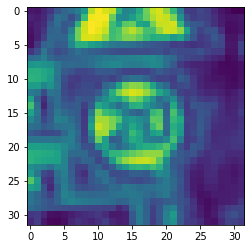

In [6]:
plt.imshow(dataset.X[0, :, :, :])

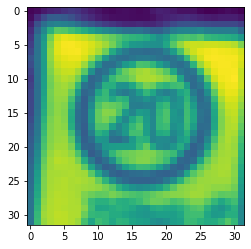

In [7]:
plt.imshow(dataset.X[100, :, :, :])

In [8]:
dataset.y[0, :]

matrix([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [9]:
dataset.y[1000, :]

matrix([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [10]:
from sklearn.model_selection import train_test_split
idx_train, idx_test = train_test_split(range(dataset.X.shape[0]),
                                       test_size=0.25,
                                       random_state=101)  # 29406train, 9803test
X_train = dataset.X[idx_train, :, :, :]
X_test = dataset.X[idx_test, :, :, :]
y_train = dataset.y[idx_train, :]
y_test = dataset.y[idx_test, :]

In [11]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(29406, 32, 32, 1)
(29406, 43)
(9803, 32, 32, 1)
(9803, 43)


In [12]:
# 构建CNN网络
from keras.models import Sequential
from keras.layers.core import Dense, Flatten
from keras.layers.convolutional import Conv2D
from keras.optimizers import SGD
from keras import backend as K
K.set_image_data_format('channels_last')


def cnn_model_1():
    model = Sequential()
    # 深度为32，核大小为3*3，输入大小为输入层32*32*1，激活函数为RELU
    model.add(
        Conv2D(32, (3, 3),
               padding='same',
               input_shape=(RESIZED_IMAGE[0], RESIZED_IMAGE[1], 1),
               activation='relu'))
    # 展平为一维数组
    model.add(Flatten())
    # 密集输出层，全连接43个单元类别
    model.add(Dense(N_CLASSES, activation='softmax'))
    return model

In [13]:
cnn = cnn_model_1()
# 定义损失函数，优化器，评分标准
cnn.compile(loss='categorical_crossentropy',
            optimizer=SGD(lr=0.001, decay=1e-6),
            metrics=['accuracy'])

In [14]:
# 训练，每批32，走10轮
cnn.fit(X_train,
        y_train,
        batch_size=32,
        epochs=10,
        validation_data=(X_test, y_test))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 29406 samples, validate on 9803 samples
Epoch 1/10
29406/29406 [==============================] - 12s 393us/step - loss: 2.2224 - acc: 0.6371 - val_loss: 0.6722 - val_acc: 0.8445
Epoch 2/10
29406/29406 [==============================] - 8s 268us/step - loss: 0.4786 - acc: 0.8974 - val_loss: 0.4014 - val_acc: 0.9127
Epoch 3/10
29406/29406 [==============================] - 8s 282us/step - loss: 0.3041 - acc: 0.9337 - val_loss: 0.3307 - val_acc: 0.9268
Epoch 4/10
29406/29406 [==============================] - 8s 274us/step - loss: 0.2173 - acc: 0.9553 - val_loss: 0.3109 - val_acc: 0.9323
Epoch 5/10
29406/29406 [==============================] - 7s 248us/step - loss: 0.1617 - acc: 0.9676 - val_loss: 0.3330 - val_acc: 0.9252
Epoch 6/10
29406/29406 [==============================] - 7s 243us/step - loss: 0.1306 - acc: 0.9754 - val_loss: 0.2849 - val_acc: 0.9395
Epoch 7/10
29406/29406 [===

In [21]:
cnn.save('cnn_gtsrb_v1.h5')

In [15]:
# Human Performance	98.84 %
# 有点过拟合

In [16]:
# 打印混淆矩阵，识别分类错误
from sklearn.metrics import classification_report, confusion_matrix


def test_and_plot(model, X, y):
    y_pred = model.predict(X)
    y_pred_softmax = np.argmax(y_pred, axis=1).astype(np.int32)
    y_test_softmax = np.argmax(y, axis=1).astype(np.int32)
    print(classification_report(y_test_softmax, y_pred_softmax))
    cm = confusion_matrix(y_test_softmax, y_pred_softmax)
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.colorbar()
    plt.tight_layout()
    plt.show()
    # log2混淆矩阵，避免为负
    plt.imshow(np.log2(cm + 1),
               interpolation='nearest',
               cmap=plt.get_cmap('tab20'))
    plt.colorbar()

             precision    recall  f1-score   support

          0       0.98      0.72      0.83        67
          1       0.90      0.95      0.93       539
          2       0.92      0.94      0.93       558
          3       0.93      0.89      0.91       364
          4       0.98      0.94      0.96       487
          5       0.85      0.92      0.88       479
          6       0.95      0.95      0.95       105
          7       0.95      0.96      0.95       364
          8       0.94      0.96      0.95       340
          9       0.97      0.98      0.98       384
         10       0.97      0.97      0.97       513
         11       0.98      0.97      0.98       334
         12       0.97      0.99      0.98       545
         13       0.98      0.98      0.98       537
         14       0.99      0.96      0.97       213
         15       0.97      0.95      0.96       164
         16       1.00      0.97      0.98        98
         17       0.99      0.99      0.99   

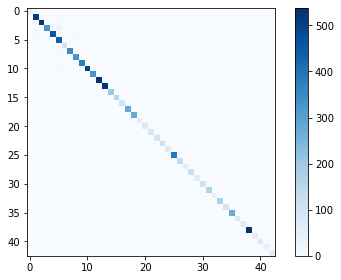

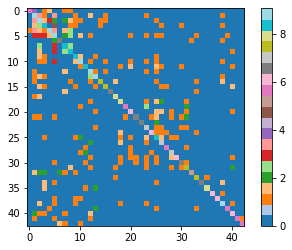

In [17]:
test_and_plot(cnn,  X_test, y_test)

In [18]:
# 改进CNN网络
from keras.layers.core import Dropout
from keras.layers.pooling import MaxPooling2D
from keras.optimizers import Adam
from keras.layers import BatchNormalization


def cnn_model_2():
    model = Sequential()
    # 深度为32，核大小为3*3，输入大小为输入层32*32*1，激活函数为RELU，第一层要有输入尺寸
    model.add(
        Conv2D(32, (3, 3),
               padding='same',
               input_shape=(RESIZED_IMAGE[0], RESIZED_IMAGE[1], 1),
               activation='relu'))
    # 标题标准化层
    model.add(BatchNormalization())
    # 深度为32，核大小为3*3，输入大小为输入层32*32*1，激活函数为RELU
    model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
    # 批量标准化层
    model.add(BatchNormalization())
    # 池化层，池大小2*2
    model.add(MaxPooling2D(pool_size=(2, 2)))
    # 丢弃层，丢弃率为0.25，防止过
    model.add(Dropout(0.4))
    # 展平层
    model.add(Flatten())
    # 全连接层，512神经元，RELU激活
    model.add(Dense(512, activation='relu'))
    # 批量标准化层
    model.add(BatchNormalization())
    # 丢弃层，丢弃率为0.5
    model.add(Dropout(0.5))
    # 全连接层，43个分类输出，得到各类概率
    model.add(Dense(N_CLASSES, activation='softmax'))
    return model

In [19]:
# 训练模型
cnn2 = cnn_model_2()
cnn2.compile(loss='categorical_crossentropy',
             optimizer=Adam(lr=0.001, decay=1e-6),
             metrics=['accuracy'])
cnn.fit(X_train,
        y_train,
        batch_size=32,
        epochs=10,
        validation_data=(X_test, y_test))



Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Train on 29406 samples, validate on 9803 samples
Epoch 1/10
29406/29406 [==============================] - 8s 263us/step - loss: 0.0530 - acc: 0.9913 - val_loss: 0.2097 - val_acc: 0.9579
Epoch 2/10
29406/29406 [==============================] - 7s 234us/step - loss: 0.0572 - acc: 0.9903 - val_loss: 0.2146 - val_acc: 0.9585
Epoch 3/10
29406/29406 [==============================] - 7s 248us/step - loss: 0.0467 - acc: 0.9924 - val_loss: 0.2193 - val_acc: 0.9598
Epoch 4/10
29406/29406 [==============================] - 7s 245us/step - loss: 0.0456 - acc: 0.9933 - val_loss: 0.2222 - val_acc: 0.9577
Epoch 5/10
29406/29406 [==============================] - 7s 249us/step - loss: 0.0469 - acc: 0.9934 - val_loss: 0.2168 - val_acc: 0.9583
Epoch 6/10
29406/29406 [==============================] - 7s 245us/step - loss: 0.0366 - acc: 0.9945 - val_loss: 0.2944 - val_acc: 0.9497
Epoch 

D:\Programing\Anaconda3\envs\tf1_env\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


             precision    recall  f1-score   support

          0       0.00      0.00      0.00        67
          1       0.00      0.00      0.00       539
          2       0.00      0.00      0.00       558
          3       0.00      0.00      0.00       364
          4       0.00      0.00      0.00       487
          5       0.00      0.00      0.00       479
          6       0.00      0.00      0.00       105
          7       0.00      0.00      0.00       364
          8       0.04      0.01      0.02       340
          9       0.00      0.00      0.00       384
         10       0.00      0.00      0.00       513
         11       0.00      0.00      0.00       334
         12       0.06      0.74      0.12       545
         13       0.00      0.00      0.00       537
         14       0.00      0.00      0.00       213
         15       0.01      0.05      0.02       164
         16       0.00      0.00      0.00        98
         17       0.01      0.01      0.01   

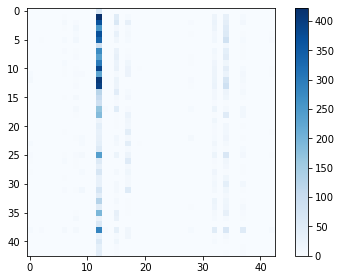

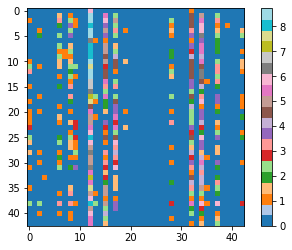

In [20]:
test_and_plot(cnn2, X_test, y_test)

In [22]:
cnn2.save('cnn_gtsrb_v2.h5')